In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from nltk import pos_tag
import nltk
#nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import gensim.downloader as api
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.math import confusion_matrix

2022-09-08 10:24:42.906377: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-08 10:24:42.973063: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-08 10:24:42.973093: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Preprocessing, Target Engineering and RNN model with Word2Vec embedding 
### on final Data Set from the OpenAlex API and ArXiv.org

In [3]:
# Reading OpenAlex Data
openalex_data = pd.read_csv('../raw_data/data_3k.csv')
openalex_data = openalex_data.drop(columns='Unnamed: 0')
openalex_data.head()

,id,title,text,topic,subtopic
0,https://openalex.org/W2100716186,Large-scale screening of hypothetical metal-or...,PUBLISHED ONLINE: 6 NOVEMBER 2011 | DOI: 10.10...,Chemistry,Nanotechnology
1,https://openalex.org/W2109370530,Routing and wavelength assignment in all-optic...,"[H+./ACM TRANSACTIONS ON NETWORKING, VO1. 3, N...",Computer science,Telecommunications
2,https://openalex.org/W2131625303,Potassium channel antibody-associated encephal...,"DOI: 10.1093/brain/awh077 Brain (2004), 127, ...",Medicine,Pediatrics
3,https://openalex.org/W2131736388,"MODBASE, a database of annotated comparative p...","D336–D346 Nucleic Acids Research, 2014, Vol. 4...",Computer science,Bioinformatics
4,https://openalex.org/W2144966005,Regional brain volume abnormalities and long-t...,ORIGINAL CONTRIBUTION Regional Brain Volume A...,Medicine,Internal medicine


In [4]:
# Reading Arxiv Data
arxiv_data = pd.read_csv('../raw_data/small_dataset.csv')
arxiv_data = arxiv_data.drop(columns='Unnamed: 0')
arxiv_data = arxiv_data.rename(columns={'0': 'text'})
arxiv_data

,text,subtopic
0,2 2 0 2 g u A 6 2 ] E H . h p - o r t s a [ ...,Astrophysics
1,"Draft version August 29, 2022 Typeset using LA...",Astrophysics
2,Astronomy & Astrophysics manuscript no. 41891c...,Astrophysics
3,Astronomy & Astrophysics manuscript no. aa Aug...,Astrophysics
4,2 2 0 2 g u A 6 2 ] R S . h p - o r t s a [...,Astrophysics
...,...,...
2030,2 2 0 2 g u A 3 2 ] A F . h t a m [ 1 v 5...,Symplectic Geometry
2031,UNIVERSIDAD COMPLUTENSE DE MADRID FACULTAD DE...,Symplectic Geometry
2032,2 2 0 2 g u A 0 2 ] G S . h t a m [ 1 v 4...,Symplectic Geometry
2033,2 2 0 2 g u A 6 1 ] G S . h t a m [ 1 v 4...,Symplectic Geometry


In [5]:
# Turning subtopics into topics
physics_list = ['astrophysics', 'condensed matter', 'general relativity and quantum cosmology', 'high energy physics - experiment', 
                'high energy physics - lattice', 'high energy physics - phenomenology', 'high energy physics - Tteory',
                'mathematical physics', 'nonlinear sciences', 'nuclear experiment', 'nuclear theory', 'physics', 'quantum physics']

arxiv_data['topic'] = arxiv_data['subtopic'].apply(lambda x: 'physics' if x.lower() in physics_list else 'mathematics')
arxiv_data

,text,subtopic,topic
0,2 2 0 2 g u A 6 2 ] E H . h p - o r t s a [ ...,Astrophysics,physics
1,"Draft version August 29, 2022 Typeset using LA...",Astrophysics,physics
2,Astronomy & Astrophysics manuscript no. 41891c...,Astrophysics,physics
3,Astronomy & Astrophysics manuscript no. aa Aug...,Astrophysics,physics
4,2 2 0 2 g u A 6 2 ] R S . h p - o r t s a [...,Astrophysics,physics
...,...,...,...
2030,2 2 0 2 g u A 3 2 ] A F . h t a m [ 1 v 5...,Symplectic Geometry,mathematics
2031,UNIVERSIDAD COMPLUTENSE DE MADRID FACULTAD DE...,Symplectic Geometry,mathematics
2032,2 2 0 2 g u A 0 2 ] G S . h t a m [ 1 v 4...,Symplectic Geometry,mathematics
2033,2 2 0 2 g u A 6 1 ] G S . h t a m [ 1 v 4...,Symplectic Geometry,mathematics


In [6]:
# Concatenating both datasets
data = pd.concat([openalex_data, arxiv_data], ignore_index=True)
data.shape

(4955, 5)

In [7]:
# Dropping duplicates
data.drop_duplicates(subset=['text'], keep='first', inplace=True, ignore_index=True)
data.shape

(3354, 5)

#### Further data cleaning is not necessary, since we built this dataset ourselves.

## Preprocessing

In [8]:
# Lowercasing everything
data = data.apply(lambda x: x.astype(str).str.lower())

In [9]:
# Removing anything apart from lower case letters 
data['text'] = data['text'].apply(lambda x: re.sub(r'[^a-z]', ' ', x))

In [10]:
# Removing anything that comes before the abstract
data['text'] = data['text'].apply(lambda x: re.sub(r"^.+?(?=abstract)", "", x))

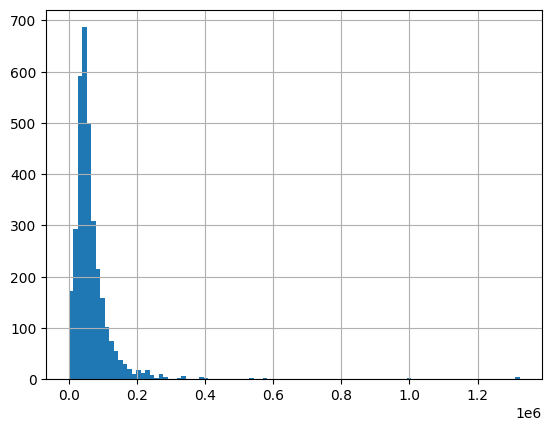

In [11]:
# This is the distribution of the total number of words per paper
data['total words per text'] = data['text'].apply(lambda x : len(x)) 
data['total words per text'].hist(bins=100);

#### In terms of computational efficiency it is reasonable to scale down the number of word taken into account from every paper. Otherwise, the file wouldn't be executable.

#### We will do so by creating a reduced list of tokens from the paper texts, that we will later use for word embedding. To increase the quality we will remove stopwords and singel letter words.

In [12]:
# Tokenizing
max_length_of_padding = 1000 # to save computational costs, we will already implement the max_length_of_padding here
num_of_words_to_keep = int(max_length_of_padding*5) # adding some margin, because in spotword removal and word2vec embedding some will be removed

data['modified text'] = data['text'].apply(lambda text: ' '.join(text.split()[:num_of_words_to_keep]))
data['modified text'] = data['modified text'].apply(word_tokenize)

In [13]:
# Lemmatizing
data['modified text'] = data['modified text'].apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos = 'v') for word in x])
data['modified text'] = data['modified text'].apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos = 'n') for word in x])

In [14]:
# Removing stopwords and single letter words
stop_words = set(stopwords.words('english'))

data['modified text'] = data['modified text'].apply(lambda x: [word for word in x if not word in stop_words])
data['modified text'] = data['modified text'].apply(lambda x: [word for word in x if len(word)>1])

In [15]:
# Keeping only the nouns
from nltk import pos_tag
import nltk
#nltk.download('averaged_perceptron_tagger')
data['modified text'] = data['modified text'].apply(lambda x: [tag[0] for tag in nltk.pos_tag(list(x)) if (tag[1]=='NN') or (tag[1]=='NNS')])

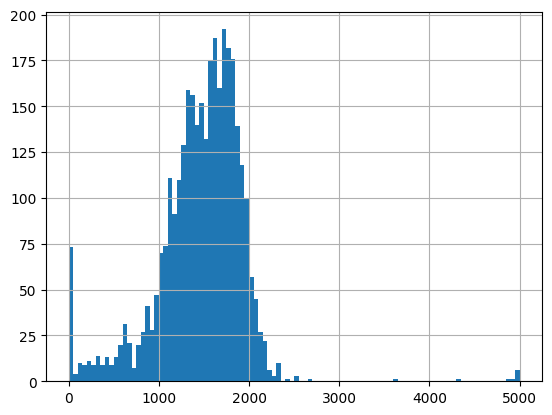

In [16]:
# This is the distribution of numbers of selected tokens per paper after cutting down
data['words per modified text'] = data['modified text'].apply(lambda x : len(x)) 
data['words per modified text'].hist(bins=100);

In [17]:
# Let's also exclude representations with less than 10 tokens
data = data[data['words per modified text'] > 9].reset_index().drop(columns=['index'], axis=1)
data.shape

(3298, 8)

#### Now we will clean our data some more by reducing the samples of uncommon targets.

## Taking Care of the Targets

In [18]:
# Let's check how our topics and subtopics are distributed
data['topic'].value_counts()

mathematics              1053
physics                   785
biology                   461
medicine                  383
chemistry                 138
computer science          134
psychology                118
materials science          58
environmental science      42
economics                  35
business                   29
geology                    21
geography                  15
sociology                  10
political science           8
engineering                 5
history                     2
art                         1
Name: topic, dtype: int64

#### Topics are highly imballanced, we'll have to take care of this later.

In [19]:
# Now checking the counts of the subtopics
data['subtopic'].value_counts()

mathematical physics    107
astrophysics            101
cell biology            101
condensed matter        100
quantum physics          89
                       ... 
political economy         1
nuclear physics           1
simulation                1
economic system           1
market economy            1
Name: subtopic, Length: 249, dtype: int64

In [20]:
# Inspecting the relationship between topics and subtopics
data.groupby(by=['topic', 'subtopic']).count()

id  title  text  total words per text  \
topic     subtopic                                                         
art       theology                  1      1     1                     1   
biology   algorithm                 1      1     1                     1   
          anatomy                   6      6     6                     6   
          archaeology               1      1     1                     1   
          biochemical engineering   1      1     1                     1   
...                                ..    ...   ...                   ...   
sociology law and economics         1      1     1                     1   
          management science        1      1     1                     1   
          public relations          2      2     2                     2   
          social psychology         1      1     1                     1   
          social science            2      2     2                     2   

                                   modified text  words per modified text  
topic     subtopic                                                         
art       theology                             1                        1  
biology   algorithm                            1                        1  
          anatomy                              6                        6  
          archaeology                          1                        1  
          biochemical engineering              1                        1  
...                                          ...                      ...  
sociology law and economics                    1                        1  
          management science                   1                        1  
          public relations                     2                        2  
          social psychology                    1                        1  
          social science                       2                        2  

[456 rows x 6 columns]

In [21]:
# Remark on the subtopics
num_subtopics = len(data['subtopic'].value_counts())
num_subtopics_grouped_by_topics = len(data.groupby(by=['topic', 'subtopic']).count())

print(f'Since the number of subtopics is {num_subtopics} and the number subtopics grouped by their topics increases to {num_subtopics_grouped_by_topics}, we can deduce, that we have subtopics, that belong to several academic fields.')

Since the number of subtopics is 249 and the number subtopics grouped by their topics increases to 456, we can deduce, that we have subtopics, that belong to several academic fields.


#### Which are these? And how common are those multiclass subtopics?

In [22]:
# Getting the subtopics that are assigned to several topics
def finding_multiassigned_subtopics():
    list_of_multiclass_subtopics = []
    for i in range(len(data.groupby(by=['subtopic', 'topic']).count())-1):
        if (data.groupby(by=['subtopic', 'topic']).count().index[i][0] == \
            data.groupby(by=['subtopic', 'topic']).count().index[i+1][0]):
            list_of_multiclass_subtopics.append(data.groupby(by=['subtopic', 'topic']).count().index[i])
            list_of_multiclass_subtopics.append(data.groupby(by=['subtopic', 'topic']).count().index[i+1])

    return list(set(list_of_multiclass_subtopics))

In [23]:
# Which multiclass assigned subtopics are the most common ones?
multiclass_subtopics = finding_multiassigned_subtopics()

df = pd.DataFrame()
for i in range(len(multiclass_subtopics)):
    extracted_data = (data[(data['subtopic'] == multiclass_subtopics[i][0]) & (data['topic'] == multiclass_subtopics[i][1])])
    extracted_data_old = df
    df = pd.concat([extracted_data_old, extracted_data], ignore_index=True)
df = df.sort_values(by='subtopic')

df.groupby(by="subtopic").count().sort_values(by='id', ascending=False)

,id,title,text,topic,total words per text,modified text,words per modified text
subtopic,,,,,,,
cell biology,101,101,101,101,101,101,101
internal medicine,80,80,80,80,80,80,80
neuroscience,68,68,68,68,68,68,68
genetics,66,66,66,66,66,66,66
immunology,63,63,63,63,63,63,63
...,...,...,...,...,...,...,...
agroforestry,2,2,2,2,2,2,2
internet privacy,2,2,2,2,2,2,2
law,2,2,2,2,2,2,2


#### We can see that some interdisciplinary subtopics (those with high transfer potential) tend to live in several academic fields.

In [24]:
# example subtopic 'cell biology' 
df[df['subtopic'] == 'cell biology']['topic'].value_counts()

biology             76
chemistry           21
computer science     2
mathematics          1
medicine             1
Name: topic, dtype: int64

#### We want to join some of the subtopics, so that we have lesser and larger subtopics to classify.

### Reducing the subtopics

In [25]:
#from .. WorkingPaper.preprocessing.utils import make_broader_subdisciplines_physics
#make_broader_subdisciplines_physics()

In [26]:
# Printing the subtopics from the field "physics", for matching purposes
print(Counter(data[data['topic'] == 'physics']['subtopic']))

Counter({'mathematical physics': 107, 'astrophysics': 101, 'condensed matter': 100, 'quantum physics': 89, 'general relativity and quantum cosmology': 87, 'high energy physics - phenomenology': 69, 'nonlinear sciences': 64, 'high energy physics - experiment': 55, 'nuclear theory': 24, 'astronomy': 21, 'nuclear experiment': 16, 'high energy physics - lattice': 12, 'quantum mechanics': 5, 'neuroscience': 4, 'classical mechanics': 4, 'computational physics': 3, 'statistical physics': 2, 'optics': 2, 'mechanics': 2, 'biological system': 2, 'chemical physics': 1, 'theoretical physics': 1, 'nuclear physics': 1, 'geometry': 1, 'systems engineering': 1, 'electrical engineering': 1, 'simulation': 1, 'applied mathematics': 1, 'atomic physics': 1, 'nuclear medicine': 1, 'quantum electrodynamics': 1, 'optoelectronics': 1, 'molecular physics': 1, 'particle physics': 1, 'astrobiology': 1, 'geochemistry': 1})


In [27]:
# Make a mapping of physics subtopics from our api data to more generalised physics subtopics
physics_mapping_dict = {'astrophysics': ['astronomy', 'astrophysics', 'astrobiology'],\
    'condensed matter': ['condensed matter', 'statistical physics', 'neuroscience', 'biological system', 'nanotechnology', 'molecular physics', 'computational physics'],\
    'general relativy and cosmology': ['classical mechanics', 'mechanics', 'optics'],\
    'high energy physics': ['atomic physics', 'particle physics'],\
    'mathematical physics': ['geometry', 'mathematical physics', 'applied mathematics', 'theoretical physics', 'pure mathematics'],\
    'nuclear': ['nuclear physics', 'nuclear medicine', 'physical medicine and rehabilitation'],\
    'quantum physics': ['quantum mechanics', 'quantum electrodinamics']}

In [28]:
# Turning the dict, which as accidentally coded the wrong way around
def turn_dict(physic_dict):
    new_dict = {}
    for key, values in physic_dict.items():
        for value in values:
            new_dict[value]=key
    return new_dict

new_mapping_dict = turn_dict(physics_mapping_dict)
new_mapping_dict

{'astronomy': 'astrophysics',
 'astrophysics': 'astrophysics',
 'astrobiology': 'astrophysics',
 'condensed matter': 'condensed matter',
 'statistical physics': 'condensed matter',
 'neuroscience': 'condensed matter',
 'biological system': 'condensed matter',
 'nanotechnology': 'condensed matter',
 'molecular physics': 'condensed matter',
 'computational physics': 'condensed matter',
 'classical mechanics': 'general relativy and cosmology',
 'mechanics': 'general relativy and cosmology',
 'optics': 'general relativy and cosmology',
 'atomic physics': 'high energy physics',
 'particle physics': 'high energy physics',
 'geometry': 'mathematical physics',
 'mathematical physics': 'mathematical physics',
 'applied mathematics': 'mathematical physics',
 'theoretical physics': 'mathematical physics',
 'pure mathematics': 'mathematical physics',
 'nuclear physics': 'nuclear',
 'nuclear medicine': 'nuclear',
 'physical medicine and rehabilitation': 'nuclear',
 'quantum mechanics': 'quantum phy

In [29]:
# Mapping the subtopics from the mapping dict to the broader subtopics
data['broader_subtopic'] = data.where(data['topic'] == 'physics')['subtopic'].map(new_mapping_dict)
data[data['topic'] == 'physics'].head()

,id,title,text,topic,subtopic,total words per text,modified text,words per modified text,broader_subtopic
41,https://openalex.org/w1955575446,sharp wave-associated high-frequency oscillati...,the journal of neuroscience january ...,physics,neuroscience,90278,"[journal, neuroscience, wave, hippocampus, net...",1858,condensed matter
44,https://openalex.org/w2025236523,entanglement measures and purification procedures,physical review a volume number march ...,physics,quantum mechanics,102312,"[review, volume, number, march, measure, puri,...",1993,quantum physics
49,https://openalex.org/w2102582588,the peregrine soliton in nonlinear fibre optics,letters published online august do...,physics,quantum mechanics,32391,"[letter, online, august, doi, peregrine, solit...",1733,quantum physics
57,https://openalex.org/w2005241888,constant temperature molecular dynamics methods,progress of theoretical physics supplement no...,physics,statistical physics,123550,"[progress, supplement, temperature, method, sh...",1257,condensed matter
94,https://openalex.org/w1969658805,on the measurement of a weak classical force c...,abstract terms focusing attention on the dy...,physics,quantum mechanics,182269,"[term, focus, attention, system, measure, evol...",1376,quantum physics


In [30]:
# Checking if it worked
data['broader_subtopic'].value_counts()

astrophysics                      123
condensed matter                  112
mathematical physics              110
general relativy and cosmology      8
quantum physics                     5
nuclear                             2
high energy physics                 2
Name: broader_subtopic, dtype: int64

In [31]:
# 'mathematical physics' is excluded (too similar to mathematics)
data = data[data['broader_subtopic'] != 'mathematical physics']
data.shape

(3188, 9)

In [32]:
# Make a mapping of biology subtopics from our api data to more generalised biology subtopics
biology_mapping_dict = {'zoology': 'zoology', 'fishery':'zoology', 'animal science':'zoology', 'oceanography': 'zoology', 'cancer research':'genetics and molecular biology', \
    'biochemical engineering': 'genetics and molecular biology', 'genetics': 'genetics and molecular biology', 'molecular biology': 'genetics and molecular biology','biochemistry': 'genetics and molecular biology', 'chromatography': 'genetics and molecular biology', \
    'biotechnology':'genetics and molecular biology', 'biophysics': 'genetics and molecular biology', 'horticulture': 'botany','forestry': 'botany', 'agroforestry': 'botany', \
    'endocrinology': 'physiology', 'immunology': 'physiology', 'neuroscience': 'physiology', 'biological system': 'physiology', \
    'cell biology': 'microbiology', 'virology': 'microbiology', 'microbiology': 'microbiology', \
    'soil science': 'ecology', 'environmental health': 'ecology', 'environmental chemistry': 'ecology', 'ecology': 'ecology', \
    'computational biology': 'computational biology', 'bioinformatics': 'computational biology', 'statistics': 'computational biology',
    'database': 'computational biology', 'data mining': 'computational biology', 'world wide web': 'computational biology', 'data science': 'computational biology', 'information retrieval': 'computational biology', 'algorithm': 'computational biology', 'programming language': 'computational biology', 'artificial intelligence': 'computational biology',\
    'evolutionary biology': 'evolutionary biology', 'botany': 'botany', 'physiology': 'physiology', 'internal medicine': 'physiology', 'anatomy': 'physiology', 'pathology':'physiology'}

# Mapping the subtopics from the mapping dict to the broader subtopics
data['broader_subtopic'] = data.where(data['topic'] == 'biology')['subtopic'].map(biology_mapping_dict)

# Checking if it worked
data['broader_subtopic'].value_counts()

genetics and molecular biology    151
microbiology                      102
physiology                         96
computational biology              54
botany                             14
evolutionary biology               13
ecology                             9
zoology                             6
Name: broader_subtopic, dtype: int64

In [33]:
# "physiology" and "computational biology" are excluded (too similar to medicine and computer science)
data = data[data['broader_subtopic'] != 'physiology']
data = data[data['broader_subtopic'] != 'computational biology']
data.shape

(3038, 9)

In [34]:
# Getting subtopics from the medical field
data[data['topic'] == 'medicine']['subtopic'].unique()

array(['pediatrics', 'internal medicine', 'psychiatry', 'cardiology',
       'intensive care medicine', 'cancer research', 'radiology',
       'immunology', 'gerontology', 'environmental health',
       'clinical psychology', 'gynecology', 'family medicine',
       'endocrinology', 'algorithm', 'neuroscience', 'pharmacology',
       'physical medicine and rehabilitation', 'oncology', 'pathology',
       'medical emergency', 'gastroenterology', 'demography', 'dentistry',
       'cell biology', 'environmental ethics', 'anatomy',
       'physical therapy', 'surgery', 'audiology', 'physiology',
       'virology', 'emergency medicine', 'optics', 'nursing',
       'medical physics', 'anesthesia', 'genetics', 'andrology',
       'nuclear magnetic resonance', 'bioinformatics', 'general surgery',
       'orthodontics', 'data science', 'microbiology', 'nuclear medicine',
       'obstetrics', 'microeconomics', 'biotechnology', 'urology',
       'computational biology', 'psychotherapist', 'medical

In [35]:
# Filtering the data to exclude interdisciplinary medical subtopics (for more distinguishability)
data = data[(data['topic'] != 'medicine') & (data['subtopic'] != 'algorithm')]
data = data[(data['topic'] != 'medicine') & (data['subtopic'] != 'cell biology')]
data = data[(data['topic'] != 'medicine') & (data['subtopic'] != 'environmental ethics')]
data = data[(data['topic'] != 'medicine') & (data['subtopic'] != 'virology')]
data = data[(data['topic'] != 'medicine') & (data['subtopic'] != 'optics')]
data = data[(data['topic'] != 'medicine') & (data['subtopic'] != 'nursing')]
data = data[(data['topic'] != 'medicine') & (data['subtopic'] != 'medical physics')]
data = data[(data['topic'] != 'medicine') & (data['subtopic'] != 'genetics')]
data = data[(data['topic'] != 'medicine') & (data['subtopic'] != 'bioinformatics')]
data = data[(data['topic'] != 'medicine') & (data['subtopic'] != 'data science')]
data = data[(data['topic'] != 'medicine') & (data['subtopic'] != 'microbiology')]
data = data[(data['topic'] != 'medicine') & (data['subtopic'] != 'microeconomics')]
data = data[(data['topic'] != 'medicine') & (data['subtopic'] != 'biotechnology')]
data = data[(data['topic'] != 'medicine') & (data['subtopic'] != 'computational biology')]
data = data[(data['topic'] != 'medicine') & (data['subtopic'] != 'psychotherapist')]
data = data[(data['topic'] != 'medicine') & (data['subtopic'] != 'animal science')]
data = data[(data['topic'] != 'medicine') & (data['subtopic'] != 'food science')]

### Getting rid of rare topics and subtopics

In [36]:
# Filtering for those topics that occurr more commonly in our data        <----- percentile can be adjusted
common_topics = (data['topic'].value_counts() > np.percentile(data['topic'].value_counts(), 80)) # topic occurrence until xxth percentile
filtered_topics = common_topics[common_topics == True].index
filtered_topics

Index(['mathematics', 'physics', 'biology', 'psychology'], dtype='object')

In [37]:
# Filtering for those subtopics that occurr more commonly in our data     <----- percentile can be adjusted
common_subtopics = (data['subtopic'].value_counts() > np.percentile(data['subtopic'].value_counts(), 80))
filtered_subtopics = common_subtopics[common_subtopics == True].index
filtered_subtopics

Index(['astrophysics', 'condensed matter', 'quantum physics', 'combinatorics',
       'general relativity and quantum cosmology', 'analysis of pdes',
       'optimization and control', 'probability',
       'high energy physics - phenomenology', 'high energy physics - theory',
       'nonlinear sciences', 'numerical analysis', 'algebraic geometry',
       'molecular biology', 'high energy physics - experiment',
       'information theory', 'dynamical systems', 'number theory',
       'biochemistry', 'neuroscience', 'differential geometry',
       'functional analysis', 'statistics theory', 'nanotechnology',
       'classical analysis and odes', 'complex variables', 'nuclear theory',
       'algebraic topology', 'representation theory', 'ecology',
       'geometric topology', 'astronomy', 'cancer research', 'group theory',
       'commutative algebra', 'biophysics', 'rings and algebras',
       'nuclear experiment', 'cognitive psychology', 'social psychology',
       'botany', 'evolutio

In [38]:
# Filtering data according to the topics and subtopics that are more common
data = data[data['subtopic'].isin(list(filtered_subtopics)) & data['topic'].isin(list(filtered_topics))]
data.shape

# There is a catch here though, because the occurrence of both, topics and subtopics, depend on each other.
# This might leave us with some scarcely represented topics and subtopics still.
# Should there be some time left before the deadline, this should be optimized.

(1729, 9)

In [39]:
# Filtering data according to the topics that are more common
#data = data[data['topic'].isin(list(filtered_topics))]

# That's much worse than filtering for common topics and subtopics at the same time. 
# Although the above procedure isn't opitmal, it's a measure to reduce all the branching, so we'll stick with it for now.

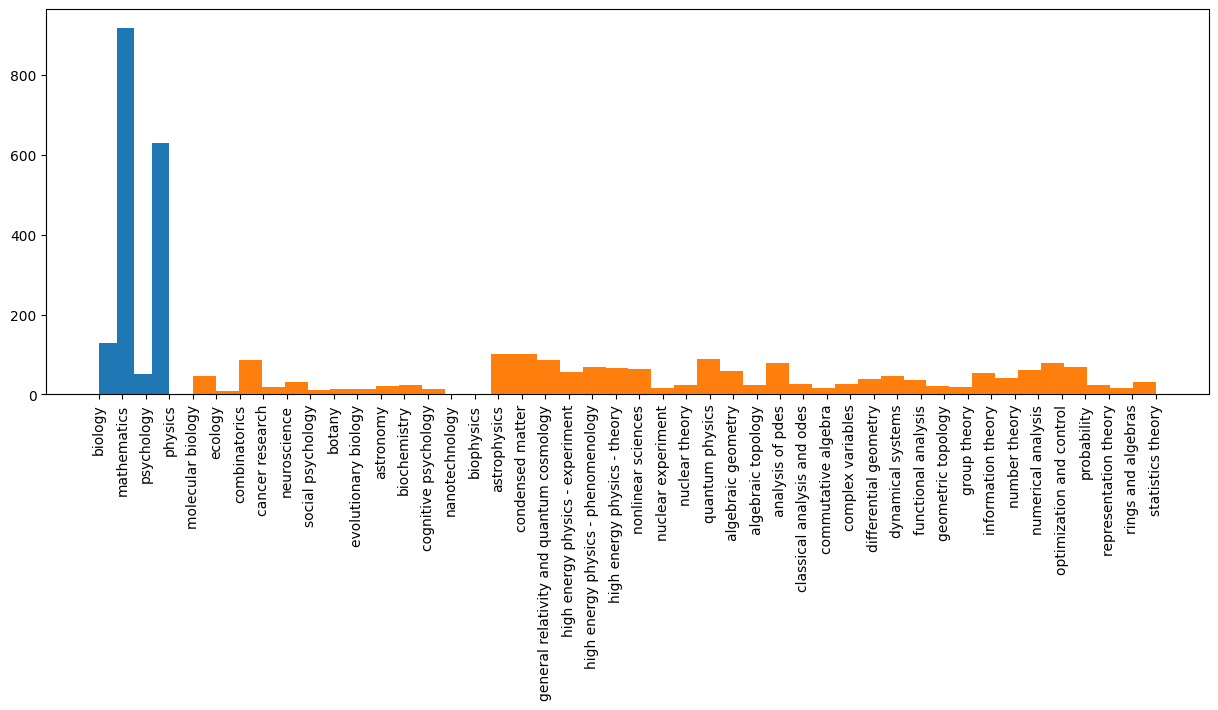

In [40]:
# The remaining topics and the subtopics are distributed as such:
plt.figure(figsize=(15, 5))
plt.hist(data['topic'], bins=data['topic'].nunique())
plt.hist(data['subtopic'], bins=data['subtopic'].nunique())
plt.xticks(rotation = 90)
plt.show()

#### For this model however, we will only use the main academic fields (in blue).

In [41]:
# Printing precise number of occurances for each topic
print(Counter(data['topic']))

Counter({'mathematics': 918, 'physics': 630, 'biology': 129, 'psychology': 52})


In [42]:
# Saving preprocessed data in a csv
data.to_csv(f'../preprocessed_data/preprocessed_3kdata_nouns.csv', index=False)

#### The topics and subtopics are highly imbalanced still. They are our targets!!! So, we need to rebalance them (in the training set only) once we made our train-test.split.

#### Before though, based on this new shape of the dataframe, we will create word embeddings with Word2Vec!

### Word2Vec embedding of the text of the scientific papers

In [43]:
# Load preprocessed data
data = pd.read_csv('../preprocessed_data/preprocessed_10kdata_nouns.csv')

In [44]:
# Downloading a pre-trained Word2Vec model, that delivers a 50 space vector representation of any word present in the Wikipedia in 2014
word2vec_transfer = api.load("glove-wiki-gigaword-50")
word2vec_transfer['saturn'].shape # checking the shape of the vectors: (50, )
print('Vocabulary size', len(word2vec_transfer))

Vocabulary size 400000


In [45]:
# Function to convert a paper (list of words) into a matrix representing the words in the embedding space
def embed_paper(word2vec_space, paper):
    embedded_paper = []
    for word in paper:
        if word in word2vec_space:
            embedded_paper.append(word2vec_space[word])
        
    return np.array(embedded_paper)

In [46]:
# Testing the function
test_sentence_embedded = embed_paper(word2vec_transfer, data['modified text'][0])
test_sentence_embedded.shape # some words have been skipped, because certainly they weren't contained in the glove-wiki-gigaword-50 representation

(13774, 50)

In [47]:
# Function to convert a list of papers into a list of matrices
def embedding(word2vec_space, series_of_papers):
    embed = []
    
    for ele in series_of_papers:
        embedded_article = embed_paper(word2vec_space, ele)
        embed.append(embedded_article)
        
    return embed

In [48]:
# Adding a column with embedded words from the papers into data frame
series_embedded = embedding(word2vec_transfer, data['modified text'])
data['embedded text'] = series_embedded
data.head()

,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,id,title,text,topic,subtopic,total words per text,modified text,words per modified text,broader_subtopic,embedded text
0,9.0,9.0,9.0,https://openalex.org/w1968762427,rapid amplification of plasmid and phage dna u...,downloaded from genome cshlp org on septem...,biology,molecular biology,23397,"['download', 'genome', 'cshlp', 'cold', 'sprin...",1504,genetics and molecular biology,"[[-0.61201, 0.98226, 0.11539, 0.014623, 0.2387..."
1,13.0,13.0,13.0,https://openalex.org/w2008205728,marginal likelihood from the metropolis–hastin...,marginal likelihood from the metropolis hastin...,mathematics,econometrics,62078,"['likelihood', 'metropolis', 'hastings', 'outp...",1416,NaN,"[[-0.61201, 0.98226, 0.11539, 0.014623, 0.2387..."
2,14.0,14.0,14.0,https://openalex.org/w2053593733,diagnosing schizophrenia in the initial prodro...,original article diagnosing schizophrenia in ...,psychology,clinical psychology,40451,"['article', 'phase', 'joachim', 'klosterko', '...",1769,NaN,"[[-0.61201, 0.98226, 0.11539, 0.014623, 0.2387..."
3,15.0,15.0,15.0,https://openalex.org/w2099571549,microbial communities in acid mine drainage,abstract the dissolution of sulfide minerals ...,biology,ecology,71203,"['dissolution', 'pyrite', 'fe', 'feass', 'chal...",1670,ecology,"[[-0.61201, 0.98226, 0.11539, 0.014623, 0.2387..."
4,19.0,19.0,19.0,https://openalex.org/w2123562143,polynomial time algorithms for multicast netwo...,abstract the famous max ow min cut theorem st...,mathematics,combinatorics,45200,"['max', 'cut', 'theorem', 'state', 'source', '...",1539,NaN,"[[-0.61201, 0.98226, 0.11539, 0.014623, 0.2387..."


In [49]:
# Saving preprocessed data in a csv
data = pd.read_csv('../preprocessed_data/preprocessed_10kdata_nouns_for_word2vec.csv')

In [50]:
# Loading preprocessed data
data = pd.read_csv('../preprocessed_data/preprocessed_10kdata_nouns_for_word2vec.csv')

In [51]:
# Padding all the embedded words
max_length_of_padding = 100
X_pad = pad_sequences(series_embedded, dtype='float32', padding='post', value=0, maxlen=max_length_of_padding)

### OneHot Encoding Targets

In [52]:
# OneHot Encoding topics
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
topic_targets_enc = pd.DataFrame(enc.fit_transform(data[['topic']]))
topic_targets_enc.columns = enc.get_feature_names_out()
topic_targets_enc

,topic_biology,topic_mathematics,topic_physics,topic_psychology
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0
...,...,...,...,...
2216,0.0,1.0,0.0,0.0
2217,0.0,1.0,0.0,0.0
2218,0.0,1.0,0.0,0.0
2219,0.0,1.0,0.0,0.0


#### Note to self: with <code>loss='sparse_categorical_crossentropy'</code> while compiling we don't need to OHE the target (which would alter the following process, but makes it more stable).

## RNN Model on Word2Vec pretrained vectors

In [53]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, topic_targets_enc, test_size=0.3)
print(X_train.shape)
print(y_train.shape)

(1554, 100, 50)
(1554, 4)


#### The rebalancing due to strongly uneven distributed targets will be done by weighting each label's contribution to the cost function inversely proportional to the frequency of the label (since SMOTE doesn't seem to work on vectorized lists of words). 
#### The Keras model.fit() method has the hypterparameter class_weight that allows us to do this.

In [54]:
# Weighting the labels as a rebalancing technique
y_integers = np.argmax(np.array(y_train), axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 1.2696078431372548,
 1: 0.6023255813953489,
 2: 0.8427331887201736,
 3: 2.7359154929577465}

#### With this dict, we will pass heigher weights for classes that are less present in our data set, that will be considered in the loss function. 
#### By doing this, we also increase the chance of overfitting to the rare labels, because our model will see the exact same X_train vectors for rarer labels several times instead of only once.
#### So we will need to add some regularization.

In [55]:
# Defining Ridge Regularization
reg_l2 = regularizers.L2(0.0001)

#### Adding two L2 regularization layers decreases the accuracy on the test set dramatically instead of increasing it. Maybe we hadn't overfit before?

In [56]:
# Experimenting with learning rate optimization for Adam   
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimized_adam = Adam(learning_rate=lr_schedule)


In [57]:
# Defining the F1 score manually
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [58]:
# Model architecture
def init_word2vev_rnn_model():
    word2vev_rnn_model = Sequential()
    word2vev_rnn_model.add(layers.Masking(input_shape=(X_train.shape[1], X_train.shape[2])))
    word2vev_rnn_model.add(layers.LSTM(20, activation='tanh'))
    #word2vev_rnn_model.add(layers.Dropout(rate=0.2)) 
    #word2vev_rnn_model.add(layers.Dense(20, activation='relu', kernel_regularizer=reg_l2))
    word2vev_rnn_model.add(layers.Dense(20, activation='relu'))
    #word2vev_rnn_model.add(layers.Dropout(rate=0.2)) 
    #word2vev_rnn_model.add(layers.Dense(15, activation='relu', kernel_regularizer=reg_l2))
    word2vev_rnn_model.add(layers.Dense(10, activation='relu'))
    #word2vev_rnn_model.add(layers.Dropout(rate=0.2)) 
    word2vev_rnn_model.add(layers.Dense(y_train.shape[1], activation='softmax'))

    word2vev_rnn_model.compile(loss='categorical_crossentropy',
                  #optimizer='adam',
                  optimizer=optimized_adam,
                  #optimizer='rmsprop',
                  metrics=['accuracy', f1_m])
    
    return word2vev_rnn_model

In [59]:
# Building the model and looking at it's summary
word2vev_rnn_model = init_word2vev_rnn_model()
word2vev_rnn_model.summary()

2022-09-08 10:34:33.707292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-08 10:34:33.707315: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-08 10:34:33.707332: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Future): /proc/driver/nvidia/version does not exist
2022-09-08 10:34:33.708349: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 100, 50)           0         
                                                                 
 lstm (LSTM)                 (None, 20)                5680      
                                                                 
 dense (Dense)               (None, 20)                420       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 4)                 44        
                                                                 
Total params: 6,354
Trainable params: 6,354
Non-trainable params: 0
_________________________________________________________________


In [60]:
# Training the model
es = EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)

history = word2vev_rnn_model.fit(X_train, y_train,
                    class_weight=d_class_weights,
          			batch_size=32,
         			epochs=500,
          			validation_split=0.3,
          			callbacks=[es])

Epoch 1/500
34/34 [==============================] - 5s 56ms/step - loss: 1.3894 - accuracy: 0.2603 - f1_m: 0.0028 - val_loss: 1.3505 - val_accuracy: 0.4261 - val_f1_m: 0.0000e+00
Epoch 2/500
34/34 [==============================] - 1s 27ms/step - loss: 1.3773 - accuracy: 0.3284 - f1_m: 0.0000e+00 - val_loss: 1.4185 - val_accuracy: 0.1777 - val_f1_m: 0.0000e+00
Epoch 3/500
34/34 [==============================] - 1s 28ms/step - loss: 1.3808 - accuracy: 0.2061 - f1_m: 0.0000e+00 - val_loss: 1.3819 - val_accuracy: 0.1777 - val_f1_m: 0.0000e+00
Epoch 4/500
34/34 [==============================] - 1s 28ms/step - loss: 1.3842 - accuracy: 0.2420 - f1_m: 0.0000e+00 - val_loss: 1.4021 - val_accuracy: 0.1777 - val_f1_m: 0.0000e+00
Epoch 5/500
34/34 [==============================] - 1s 28ms/step - loss: 1.3737 - accuracy: 0.2686 - f1_m: 0.0000e+00 - val_loss: 1.4024 - val_accuracy: 0.1777 - val_f1_m: 0.0000e+00
Epoch 6/500
34/34 [==============================] - 1s 27ms/step - loss: 1.3763 - a

In [61]:
# Model evaluation with X_test
loss, acc, f1 = word2vev_rnn_model.evaluate(X_test, y_test, verbose=0)

print(f'Accuracy: {acc}, F1-Score: {f1}')

Accuracy: 0.40929535031318665, F1-Score: 0.0


### Understanding model functioning with confusion matrix

21/21 [==============================] - 1s 6ms/step
0 topic_biology
1 topic_mathematics
2 topic_physics
3 topic_psychology


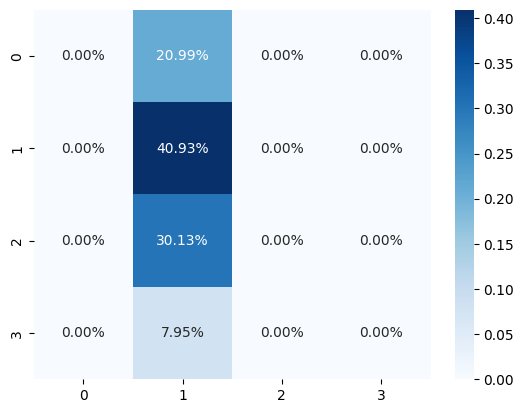

In [62]:
# Making a confusion matrix
y_test_id = np.argmax(np.array(y_test), axis=1)
y_pred_id = np.argmax(word2vev_rnn_model.predict(X_test), axis=1)
conf_matrix = confusion_matrix(labels=y_test_id, predictions=y_pred_id)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues')
for i, column in enumerate(topic_targets_enc.columns):
    print(i, column)

#### Model is underfitting and hardly learning anything.